Before we get to the actual task you will have to run the following code cells. These get the colaboratory backend set up properly.

In [ ]:
!pip install pydot_ng
!apt-get install graphviz
!pip install graphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [2]:
# basic libraries you need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# these libraries are need for the tree visualization (which is provided)
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from graphviz import Source
import pydot_ng as pydot

# These are the functions from sklearn we recommend using for this assignment
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score

# The following is code for uploading a file to the colab.research.google 
# environment.

# library for uploading files
from google.colab import files 

def upload_files():
    # initiates the upload - follow the dialogues that appear
    uploaded = files.upload()

    # verify the upload
    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))

    # uploaded files need to be written to file to interact with them
    # as part of a file system
    for filename in uploaded.keys():
        with open(filename, 'wb') as f:
            f.write(uploaded[filename])

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


# Decision Tree Task

For this task you will be building a model to predict if a breast mass is malignant or benign. The dataset we provided contains 30 features and 1 binary class label. The label is whether the mass is malignant or benign. The features describe some characteristics of the cell nuclei in the mass. More information about the dataset we will be using can be found here:

https://www.kaggle.com/uciml/breast-cancer-wisconsin-data

We want two things out of this task:

1) An evaluation of a decision tree algorithm using cross validation

2) A visualization of the resulting white box model

This notebook will lead you through step-by-step what you should do to accomplish points 1) and 2). This notebook assumes you have done the Friday evening portions of the module. Feel free to borrow code that you wrote on Friday evening.

### Load Data

load the data using the upload files function. If you are working locally, set the path in read_csv to be a path on your local machine.

In [ ]:
# upload the breast-cancer-data.csv file
upload_files()

In [3]:
# load the following data frame
cancer_df = pd.read_csv("breast-cancer-data.csv")

Do some basic EDA on the DataFrame. If you did not take module 2 (where we learnt more about EDA), just execute the .head() and .info() methods.



In [ ]:
#EDA

In [ ]:
cancer_df.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')

In [ ]:
cancer_df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [ ]:
cancer_df.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


In [ ]:
cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

### Initialize the display_tree function

We have provided a function for displaying the contents of a tree. Note that if your tree is too deep or wide it will be difficult to read. Run the following code cell so you can use the function later:

In [4]:
def display_tree(tree):
    """
    args:
        tree -  a DecisionTreeClassifier object that has been trained.
    """
    dot_data = StringIO()
    Source(export_graphviz(tree,
                           out_file=dot_data,
                           filled=True,
                           rounded=True,
                           special_characters=True,
                           class_names=["Benign", "Malignant"],
                           feature_names=features.columns))
    graph = pydot.graph_from_dot_data(dot_data.getvalue())

    graph.write_png("tmp_image.png")
    tmp_image = plt.imread("tmp_image.png")

    plt.figure(figsize=(20, 10))
    plt.imshow(tmp_image)
    plt.grid(False)

### Preparing the data

Use the following code to split the dataset into features and labels. This will convert the labels into 1 or 0 (for malignant or benign respectively). After running this, `features` will contain the features and `labels` will contain the labels.

In [5]:
# sets the random seed. This makes it so your experiments are reproducible
np.random.seed(1337)

# the label column is call diagnosis. Grab just that column and
# convert to 1 or 0
label_column_name = "diagnosis"
labels = cancer_df.loc[:, label_column_name]
labels = labels.apply(lambda x: 1 if x=="M" else 0)

# everything from column 2 and on is a feature
feat_column_names = list(cancer_df.columns[2:-1])
features = cancer_df.loc[:, feat_column_names]

In [6]:
labels

0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: diagnosis, Length: 569, dtype: int64

In [7]:
features

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


### The Cross Validation

This is where you take over. Perform 5-fold Stratified Cross Validation using the features and labels prepared for you. You should use the DecisionTreeClassifier model. Information about that model can be found here:

http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

Note that you should be able to get away with default parameter values, except for max_depth. I recommend something small (e.g. 2, 3, or 4) to make the tree easier to visualize. Feel free to play around with the other values if you want, **but** you should leave that until you have finished the task (so that you have enough time).

Evaluate the results of your cross validation using the accuracy, precision, and recall scores. sklearn functions for computing those scores have been imported for you. The API docs for them are here:

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html
http://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html

Score should be computed on all the predictions at once i.e. there will be one score for each metric. Collect the true labels and predictions for each fold and compute the metric at the end. Hint: Lists in python have a method call .extend() which lets you put the contents of one list or iterable into the list you are call extend with.


In [11]:
## Put your cross validation code here!


skf = StratifiedKFold(n_splits=5, shuffle=True)

preds= []
lbls = []

for train_indices, test_indices in skf.split(features, labels):
    train_features = features.iloc[train_indices]
    train_labels = labels.iloc[train_indices]

    model = DecisionTreeClassifier()
    model.fit(train_features,train_labels)

    test_features = features.iloc[test_indices]
    test_labels = labels.iloc[test_indices]
    print (f"Training size: {len(train_features)}, Test size: {len(test_features)}")
    
    preds.extend(model.predict(test_features))
    lbls.extend(test_labels)

model.fit(features,labels)
#TRAIN ON ENTIRE DATA

Training size: 455, Test size: 114
Training size: 455, Test size: 114
Training size: 455, Test size: 114
Training size: 455, Test size: 114
Training size: 456, Test size: 113


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [9]:

print(f"The accuracy score of the Decision Tree is: {accuracy_score(lbls,preds)}")
print(f"The precision score of the Decision Tree is: {precision_score(lbls,preds)}")
print(f"The recall score of the Decision Tree is: {recall_score(lbls,preds)}")

The accuracy score of the Decision Tree is: 0.9138840070298769
The precision score of the Decision Tree is: 0.8790697674418605
The recall score of the Decision Tree is: 0.8915094339622641


### Visualize the tree

To see what a decision tree on this data might look like (white box model) we are going to have you train another tree using the **whole** dataset and display the resulting tree. Train a new tree using `features` and `labels`. After, call the display_tree method the resulting tree object as an argument.

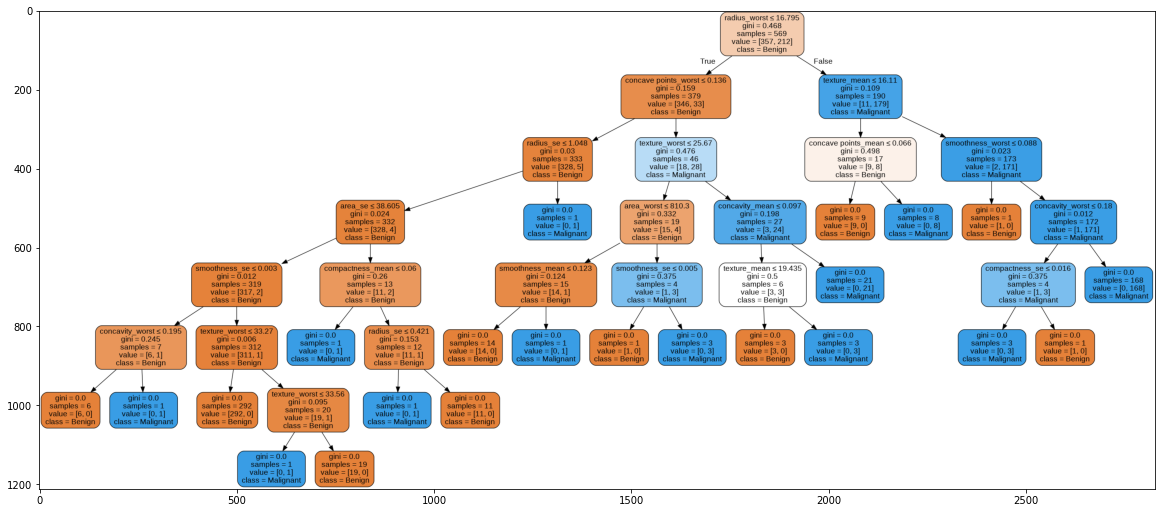

In [12]:
# code goes here
display_tree(model)

## **PLAYING AROUND WITH DECISION TREE DEPTH**

**Model 2**

---

Max Depth = 3

In [ ]:
## Put your cross validation code here!


skf = StratifiedKFold(n_splits=5, shuffle=True)

preds2 = []
lbls2 = []

for train_indices, test_indices in skf.split(features, labels):
    train_features = features.iloc[train_indices]
    train_labels = labels.iloc[train_indices]

    model2 = DecisionTreeClassifier(max_depth = 3)
    model2.fit(train_features,train_labels)

    test_features = features.iloc[test_indices]
    test_labels = labels.iloc[test_indices]
    print (f"Training size: {len(train_features)}, Test size: {len(test_features)}")
    
    preds2.extend(model.predict(test_features))
    lbls2.extend(test_labels)

print(f"The accuracy score of the Decision Tree is: {accuracy_score(lbls2,preds2)}")
print(f"The precision score of the Decision Tree is: {precision_score(lbls2,preds2)}")
print(f"The recall score of the Decision Tree is: {recall_score(lbls2,preds2)}")


Training size: 455, Test size: 114
Training size: 455, Test size: 114
Training size: 455, Test size: 114
Training size: 455, Test size: 114
Training size: 456, Test size: 113
The accuracy score of the Decision Tree is: 0.9894551845342706
The precision score of the Decision Tree is: 0.9858490566037735
The recall score of the Decision Tree is: 0.9858490566037735


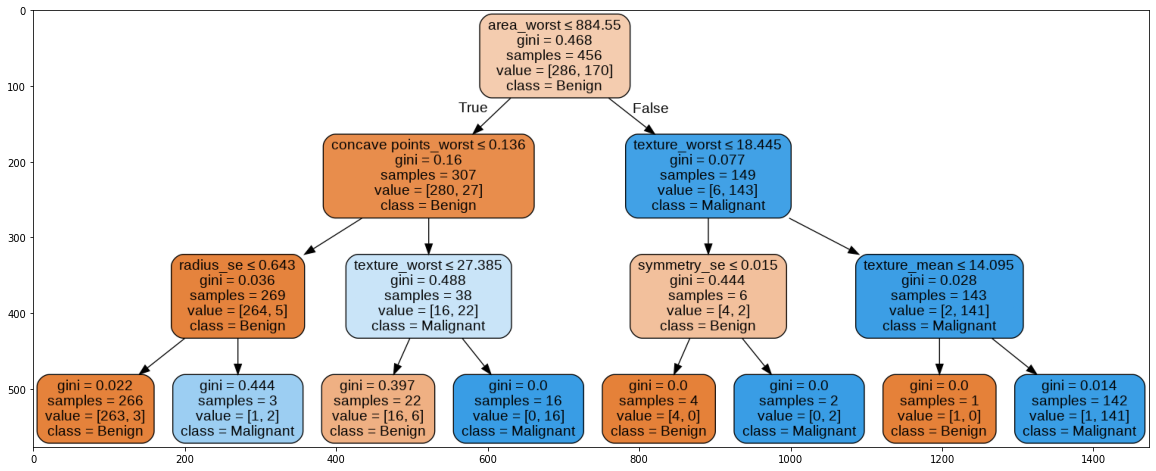

In [ ]:
# code goes here
display_tree(model2)

**Model 3**

---

Max Depth = 2

In [ ]:
## Put your cross validation code here!


skf = StratifiedKFold(n_splits=5, shuffle=True)

preds3 = []
lbls3 = []

for train_indices, test_indices in skf.split(features, labels):
    train_features = features.iloc[train_indices]
    train_labels = labels.iloc[train_indices]

    model3 = DecisionTreeClassifier(max_depth = 2)
    model3.fit(train_features,train_labels)

    test_features = features.iloc[test_indices]
    test_labels = labels.iloc[test_indices]
    print (f"Training size: {len(train_features)}, Test size: {len(test_features)}")
    
    preds3.extend(model.predict(test_features))
    lbls3.extend(test_labels)

print(f"The accuracy score of the Decision Tree is: {accuracy_score(lbls3,preds3)}")
print(f"The precision score of the Decision Tree is: {precision_score(lbls3,preds3)}")
print(f"The recall score of the Decision Tree is: {recall_score(lbls3,preds3)}")


Training size: 455, Test size: 114
Training size: 455, Test size: 114
Training size: 455, Test size: 114
Training size: 455, Test size: 114
Training size: 456, Test size: 113
The accuracy score of the Decision Tree is: 0.9894551845342706
The precision score of the Decision Tree is: 0.9858490566037735
The recall score of the Decision Tree is: 0.9858490566037735


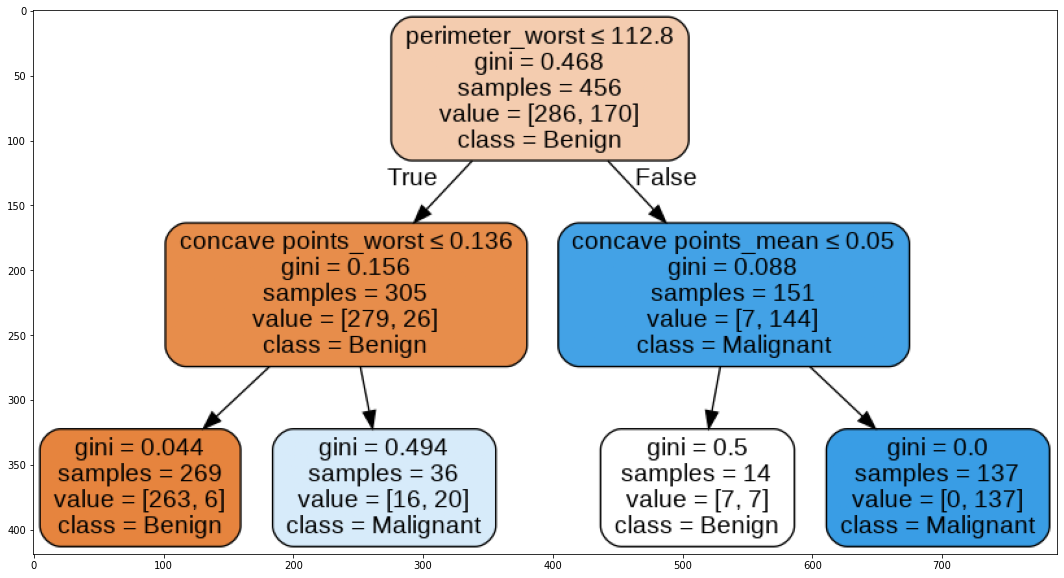

In [ ]:
# code goes here
display_tree(model3)

**Model 4**

---

criterion = entropy

In [ ]:
## Put your cross validation code here!


skf = StratifiedKFold(n_splits=5, shuffle=True)

preds4 = []
lbls4 = []

for train_indices, test_indices in skf.split(features, labels):
    train_features = features.iloc[train_indices]
    train_labels = labels.iloc[train_indices]

    model4 = DecisionTreeClassifier(criterion='entropy')
    model4.fit(train_features,train_labels)

    test_features = features.iloc[test_indices]
    test_labels = labels.iloc[test_indices]
    print (f"Training size: {len(train_features)}, Test size: {len(test_features)}")
    
    preds4.extend(model.predict(test_features))
    lbls4.extend(test_labels)

print(f"The accuracy score of the Decision Tree is: {accuracy_score(lbls4,preds4)}")
print(f"The precision score of the Decision Tree is: {precision_score(lbls4,preds4)}")
print(f"The recall score of the Decision Tree is: {recall_score(lbls4,preds4)}")


Training size: 455, Test size: 114
Training size: 455, Test size: 114
Training size: 455, Test size: 114
Training size: 455, Test size: 114
Training size: 456, Test size: 113
The accuracy score of the Decision Tree is: 0.9894551845342706
The precision score of the Decision Tree is: 0.9858490566037735
The recall score of the Decision Tree is: 0.9858490566037735


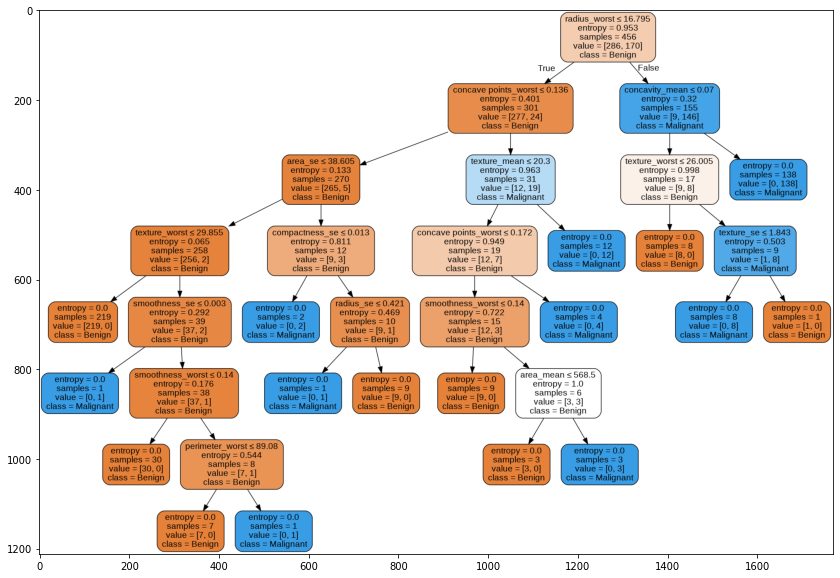

In [ ]:
# code goes here
display_tree(model4)